In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai import * 
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *

import pandas as pd
import numpy as np
import os

fastai.version.__version__

'1.0.39'

In [3]:
# make sure CUDA is available and enabled
print('CUDA enabled:',torch.cuda.is_available()) 
print('CUDNN enabled:', torch.backends.cudnn.enabled)

CUDA enabled: True
CUDNN enabled: True


# Dataset preprocessing

In [4]:
current_dir = os.getcwd()
input_path =f'{current_dir}/data'
train_dir = f"{input_path}/train"
train_labels = f"{input_path}/train.csv"
test_dir = f"{input_path}/test"
model_dir = f'{current_dir}/models'

## Train model

In [5]:
df = pd.read_csv(train_labels)
df = df.sample(frac=0.25)
df = df.reset_index()

print(df.shape)
print(df.head())

(6340, 3)
   index          Image         Id
0   8814  59a149ef2.jpg  new_whale
1  15504  9c3ee0961.jpg  w_57abc0f
2   4606  2f2107974.jpg  new_whale
3    350  03776d685.jpg  w_0b398b2
4  21004  d39ab8a23.jpg  w_a8b34a0


In [6]:
grouped_df = df.groupby('Id')
grouped_counted = grouped_df.count().sort_values(by=['Image'], ascending=False)
grouped_counted = grouped_counted[(grouped_counted['Image']>=4) ]
print(len(grouped_counted))
print(grouped_counted.sum().Image, 'of', len(df))
print(grouped_counted.head())

181
3471 of 6340
           index  Image
Id                     
new_whale   2372   2372
w_9b5109b     19     19
w_700ebb4     16     16
w_23a388d     16     16
w_5a2634c     16     16


In [7]:
valid_pct = 0.25

valid_filenames = pd.DataFrame(columns=df.columns)

for name, group in enumerate(grouped_df):
    sub_df = group[1]
    sample = sub_df.sample(frac=valid_pct)
    valid_filenames = valid_filenames.append(sample, ignore_index=True)

In [8]:
valid_filenames.drop(labels=['index'], axis=1, inplace=True, errors='ignore')

print(valid_filenames.shape)
print(valid_filenames.head())

(1022, 2)
           Image         Id
0  e00c1bcab.jpg  new_whale
1  7e2607297.jpg  new_whale
2  5699de41b.jpg  new_whale
3  2c6797778.jpg  new_whale
4  abd70059e.jpg  new_whale


In [9]:
fn2label = {row[1].Image: row[1].Id for row in df.iterrows()}
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)

In [10]:
valid_files = ItemList.from_df(df=valid_filenames, path=train_dir, cols=['Image'])

In [11]:
test_files = ImageItemList.from_folder(test_dir)

In [12]:
#data.show_batch(rows=3, fig_size=(SZ, SZ))

# Learning rate

In [13]:
tfms = get_transforms(max_zoom = 1.25)

In [23]:
SZ = 209
BS = 64
NUM_WORKERS = 8

In [24]:
# data_lr = (
#     ImageItemList
#         .from_df(df, train_dir, cols=['Image'])
# #         .no_split()
#         .split_by_files(valid_files)
#         .label_from_func(lambda path: fn2label[path2fn(path)])
#         .add_test(test_files)
#         .transform(tfms, size=SZ, resize_method=ResizeMethod.SQUISH)
#         .databunch(bs=BS, num_workers=NUM_WORKERS, path=input_path)
#         .normalize(imagenet_stats)
# )

In [25]:
# num_classes  = df['Id'].unique().shape[0]

In [26]:
from fastai.vision.models import *
from fastai.vision import *

arch = Darknet(num_blocks = [1,2,8,8,4], num_classes=num_classes)
# learn = Learner(data_lr, arch, metrics=accuracy).to_fp16().mixup()

In [27]:
# learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


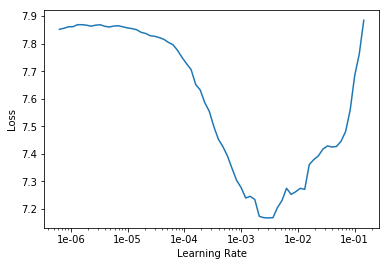

In [28]:
# learn.recorder.plot()

# Train Model

In [30]:
data = (
    ImageItemList
        .from_df(df, train_dir, cols=['Image'])
#         .no_split()
        .split_by_files(valid_files)
        .label_from_func(lambda path: fn2label[path2fn(path)])
        .add_test(test_files)
        .transform(tfms, size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path=input_path)
        .normalize(imagenet_stats)
)

In [34]:
# learn = create_cnn(data, arch, metrics=accuracy, model_dir=model_dir, callback_fns=ShowGraph)
learn = Learner(data_lr, arch, metrics=accuracy, model_dir=model_dir, callback_fns=ShowGraph).to_fp16().mixup()

In [35]:
#learning rate from LR_FINDER
lr_rate = 2e-4
# check number of cycles
learn.fit_one_cycle(10, max_lr=lr_rate)

epoch,train_loss,valid_loss,accuracy


RuntimeError: CUDA out of memory. Tried to allocate 196.00 MiB (GPU 0; 11.17 GiB total capacity; 10.68 GiB already allocated; 47.88 MiB free; 120.61 MiB cached)

In [ ]:
learn.unfreeze()
#learning rate from LR_FINDER / 10 
lr_rate = lr_rate/10
# should be /3 or /10 ?
# check number of cycles
learn.fit_one_cycle(10, wd=1e-4, max_lr=[lr_rate/100, lr_rate/10, lr_rate])

# Prediction & Summition - TODO

In [ ]:
log_preds,y = learn.TTA(ds_type=DatasetType.Test)

In [ ]:
def top_preds(preds, classes):
    top = np.argsort(preds.numpy())[:, ::-1][:, :5]
    labels = []
    for i in range(top.shape[0]):
        labels.append(' '.join([classes[idx] for idx in top[i]]))
    return labels

def create_submission(preds, data):
    classes = data.classes
    sub_df = pd.DataFrame({'Image': [path.name for path in data.test_ds.x.items]})
    sub_df['Id'] = top_preds(preds, classes)
    return sub_df

In [ ]:
submittion_df = create_submission(log_preds, learn.data)

In [ ]:
submittion_file = 'submission-4-darknet53.csv'
submittion_df.to_csv(submittion_file, index=False)

In [ ]:
print(submittion_df.head())
print(submittion_df.shape)

In [ ]:
!kaggle competitions submit -c humpback-whale-identification -f {submittion_file} -m "check darknet53 as model"